<a href="https://colab.research.google.com/github/DrakeShadowRaven/desihigh/blob/main/2bodyedited.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/desihigh')

In [ ]:
import time
import astropy
import itertools
import matplotlib

import numpy             as np
import pylab             as pl
import matplotlib.pyplot as plt
import astropy.units     as u

from   astropy.cosmology import FlatLambdaCDM
from   IPython.display   import YouTubeVideo
from   tools.flops       import flops

In [ ]:
from IPython.display import clear_output
from time import sleep

In [ ]:
%matplotlib inline

plt.style.use('dark_background')

# DESI and the fastest supercomputer in the West

Understanding _how_ the 30 million galaxies surveyed by DESI actually formed in the Universe is hard, really hard.  So hard in fact that DESI scientists exploit [Summit](https://www.olcf.ornl.gov/summit/), the world's fastest supercomputer[<sup>1</sup>](#Footnotes) at Oak Ridge National Lab to calculate how the distribution of galaxies should look depending on the type of Dark Energy:     

<img src="https://github.com/sheejong/desihigh/blob/main/desihigh/images/summit.jpg?raw=1" alt="Drawing" style="width: 800px;"/>

Costing a cool 325 million dollars to build, Summit is capable of calculating addition and multiplication operations $1.486 \times 10^{17}$ times a second, equivalent to $1.486 \times 10^{11}$ MegaFlops or MFLOPS.  For comparison, let's see what Binder provides (you'll need some patience, maybe leave this to later): 

So Summit is at least a billion times more powerful!  With Summit, we can resolve the finest details of the distribution of _dark matter_ that all galaxies trace:

<img src="https://github.com/sheejong/desihigh/blob/main/desihigh/images/abacus.png?raw=1" alt="Drawing" style="width: 600px;"/>

Here the brightest regions signify the densest regions of dark matter in the Universe, in which we expect to find more galaxies (for some zoom-ins, [click here](https://lgarrison.github.io/halos/)).  The video below shows that we have observed this predicted structure in the distribution of real galaxies observed with experiments prior to DESI:

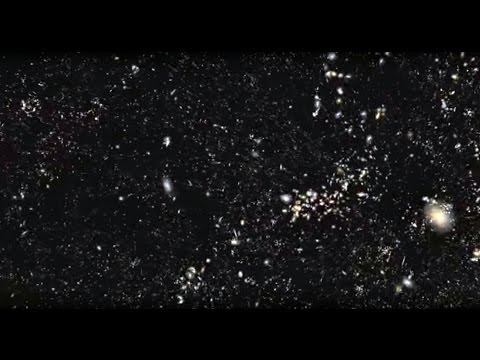

In [ ]:
YouTubeVideo('08LBltePDZw', width=800, height=400)

[Dark matter](https://en.wikipedia.org/wiki/Dark_matter#:~:text=Dark%20matter%20is%20a%20form,%E2%88%9227%20kg%2Fm3.) is a pervasive element in our Universe, making up 25% of the total (energy) density.  With Dark Energy and the common atom ("baryonic matter") making up the remainder.  We know next to nothing about Dark Matter, beyond its gravitational attraction of other matter and light in the Universe.

Fortunately, the equations that describe the evolution of dark matter, rather than the [complex formation of galaxies](https://www.space.com/15680-galaxies.html), are relatively simple for the Universe in which we seem to live.  All that is required is to track the gravitational attraction of dark matter particles (on an expanding stage).

We can predict the evolution of dark matter by sampling the gravitational force, velocity and position with a set of (fictitious) particles that each represent a 'clump' of dark matter with some total mass.  Of course, this means we cannot solve for the distribution of dark matter within these clump sized regions, but just the distribution amongst clumps that leads to the structure you can see above.  With Summit, the smallest clump we can resolve is not far from the combined mass of all the stars in the [Milky Way](https://www.nasa.gov/feature/goddard/2019/what-does-the-milky-way-weigh-hubble-and-gaia-investigate):

<img src="https://github.com/sheejong/desihigh/blob/main/desihigh/images/MilkyWay.jpg?raw=1" alt="Drawing" style="width: 1000px;"/>

To start,  we'll initially postition a set of clumps at random positions within a 3D cube and give them zero initial velocities.  Velocities will be generated at subsequent times as the ($1/r^2$) gravitational attraction of a particle to all others causes a net acceleration.

In [ ]:
def init_dof(npt=1):
  #  Create a set of particles at random positions in a box, which will soon predict the distribution of dark matter 
  #  as we see above.
  xs     = np.random.uniform(0., 1., npt)
  ys     = np.random.uniform(0., 1., npt)
  zs     = np.random.uniform(0., 1., npt)

  pos    = np.vstack((xs,ys,zs)).T
  vel    = np.zeros_like(pos)

  return  pos, vel

The gravitational force experienced by each dark matter particle is [Newton's](https://en.wikipedia.org/wiki/Isaac_Newton) $F = \frac{GmM}{r^2} \hat r$ that you may be familiar with.  We just need to do a thorough job on the book keeping required for to calculate the total force experienced by one particle due to all others:

In [ ]:
def g_at_pos(pos, particles, mass, epsilon=1.0, doimages=True):
    # eqn. (10) of http://www.skiesanduniverses.org/resources/KlypinNbody.pdf.
    # Here epsilon is a fudge factor to stop a blow up of the gravitational force at zero distance.
    
    delta_r = particles - pos
    result  = mass * np.sum(delta_r / (delta_r**2. + epsilon**2.)**(3./2.), axis=0)
    
    # If 'pos' is one of the particles, then technically we've including the "self-force"
    # But such a pos will have delta_r = 0, and thus contribute nothing to the total force, as it should!

    if doimages:
        # Our simulation assumes periodic boundary conditions, so for the acceleration of each particle, there's a 
        # corresponding acceleration due to the image of the particle produced by applying periodic shifts to its
        # position.
        shift  = np.array([-1, 0, 1])
        images = []

        for triple in itertools.product(shift, repeat=3):
            images.append(triple)
    
        images.remove((0, 0, 0))
    
        images = np.array(images)
    
        for image in images:
            delta_r_displaced = delta_r + image
            result += mass * np.sum(delta_r_displaced / (delta_r_displaced**2. + epsilon**2.)**(3./2.), axis=0)

    return  result

In a remarkable experiment in 1941, Erik Holmberg used the fact that the brightness of light decays with distance at the same ($1/r^2$) rate as gravity.  To calculate the total force on a 'particle' in his 'simulation', Holmberg placed a lightbulb at the position of each particle and calculated the effective force on a given particle by measuring the total brightness at each point!  The figure below illustrates this idea.

Try running the following cell a few times!  You'll get a different random layout of "lightbulbs" each time.

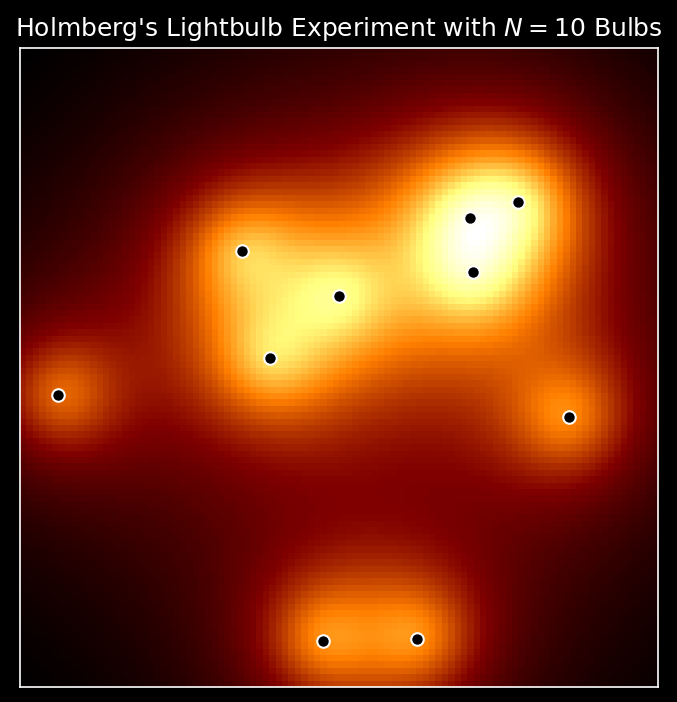

In [ ]:
fig, ax   = plt.subplots(1, 1, figsize=(5,5), dpi=150)

xmin, xmax, ymin, ymax = (0., 1., 0., 1.)

Ngrid     = 100
xx, yy    = np.meshgrid(np.linspace(xmin, xmax, Ngrid), np.linspace(ymin, ymax, Ngrid))
epsilon   = 0.1

weights   = np.zeros_like(xx)

npt = 10
pos, vel  = init_dof(npt=npt)

for par in pos:
  weights += 1. / ((xx - par[0])**2 + (yy - par[1])**2 + epsilon**2.)

ax.imshow(weights, extent=(xmin, xmax, ymin, ymax), cmap=plt.cm.afmhot, alpha=1., origin='lower')

ax.scatter(pos[:,0], pos[:,1], color='k', edgecolor='w')
ax.tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)
ax.set_title(f"Holmberg's Lightbulb Experiment with $N={npt}$ Bulbs")

ax.set_xlim(0., 1.)
ax.set_ylim(0., 1.)
fig.tight_layout()

This work was the original concept of gravitational 'N-body' simulations that are described here.  It's almost criminal that only 118 authors have referenced this groundbreaking idea!

<img src="https://github.com/sheejong/desihigh/blob/main/desihigh/images/Holmberg.png?raw=1" alt="Drawing" style="width: 800px;"/>

Today, given the mini supercomputers we often have at our fingertips, we can determine the final distribution of dark matter more accurately with computers than light bulbs.  By evolving an initial homogeneous distribution (a nearly uniform distribution of dark matter clumps, as the universe produces in the Big Bang), we can accurately predict the locations of galaxies (the places where the biggest dark matter clumps form).

To do this, we just need to calculate the acceleration on each particle at a series of time steps and update the velocity and position accordingly according to the acceleration that particle experiences.  You'll be familiar with this as the sensation you feel as a car turns a corner, or speeds up. 

In [ ]:
# We'll sample the equations of motion in discrete time steps. 
dt         = 5e-4
nsteps     = 500
timesteps  = np.linspace(0, (nsteps)*dt, nsteps, endpoint=False)

# Number and mass of particles
npt        = 3
#mass       = 0.25

# Whether to draw arrows for the acceleration and velocity
draw_acc   = False
#draw_vel   = False
draw_vel = True

# A small drag term to simulate the real drag dark matter particles experience due to the expanding universe
drag = 1e-2

Now we simply have to run the simulation!

In [ ]:
# Reinitialise particles.
pos, vel = init_dof(npt=npt)
mass = np.random.uniform(0., 1., npt)
msize = mass*20
print, mass

# force the last mass very small
mass[2]=0

print,mass
# pos of partile 1

i = 0
pos[i][0]=0.5
pos[i][1]=0.5
pos[i][2]=0.5
pos[0]

i = 1 
pos[i][0]=0.7
pos[i][1]=0.5
pos[i][2]=0.5

i = 2
pos[i][0]=0.7
pos[i][1]=0.57
pos[i][2]=0.5


# vel of partile 1

i = 0
vel[i][0]=0.1
vel[i][1]=0.05
vel[i][2]=0.1
vel[0]

i = 1 
vel[i][0]=0.05
vel[i][1]=0.1
vel[i][2]=0.2

i = 2
vel[i][0]=0.01
vel[i][1]=0.02
vel[i][2]=0.1


In [ ]:
mass

array([0.26188342, 0.35247666, 0.        ])

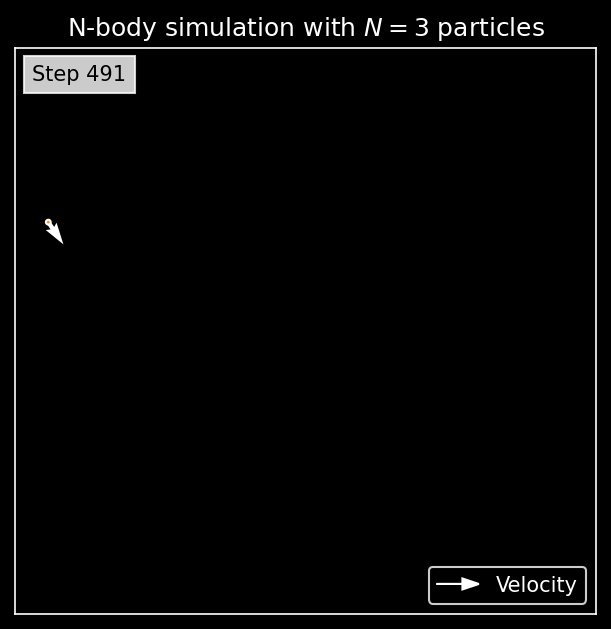

In [ ]:




# A helper function to make a nice-looking legend for our arrows
# from https://stackoverflow.com/a/22349717
def make_legend_arrow(legend, orig_handle,
          xdescent, ydescent,
          width, height, fontsize):
    p = matplotlib.patches.FancyArrow(0, 0.5*height, width, 0, length_includes_head=True, head_width=0.75*height)
    return p

for index_in_timestep, time in enumerate(timesteps):
    clear_output(wait=True)
    if index_in_timestep%10 == 1:
        fig, ax = plt.subplots(1,1, figsize=(5,5), dpi=150)
        ax.tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)
        ax.clear()
        ax.set_title(f'N-body simulation with $N={npt}$ particles')
        step_label = ax.text(0.03, .97, f'Step {index_in_timestep}',
            transform=ax.transAxes, verticalalignment='top', c='k',
            bbox=dict(color='w', alpha=0.8))
        
    dvel                        = np.zeros_like(vel)
    dpos                        = np.zeros_like(pos)
    acc                         = np.zeros_like(pos)
    for index_in_particle in range(npt):
        acc[index_in_particle]  = g_at_pos(pos[index_in_particle], pos, mass, epsilon=0.1)
        # Update velocities.
        dvel[index_in_particle] = dt * acc[index_in_particle]
        # Update positions.
        dpos[index_in_particle] = dt * vel[index_in_particle]
    vel += dvel - drag*vel
    pos += dpos
    # Our simulation has periodic boundaries, if you go off one side you come back on the other!
    pos = pos % 1
    ax.scatter(pos[:,0], pos[:,1], s=msize, color='darkorange', edgecolor='w')
    # Draw arrows representing the velocity and acceleration vectors, if requested
    # The code here is a little verbose to get nice-looking arrows in the legend
    arrows = []
    if draw_vel:
        ax.quiver(pos[:,0], pos[:,1], vel[:,0], vel[:,1], color='w', zorder=0)
        arrows += [matplotlib.patches.FancyArrow(0,0, 0.5, 0.6, label='Velocity', color='w')]
    if draw_acc:
        ax.quiver(pos[:,0], pos[:,1], acc[:,0], acc[:,1], color='darkorange', zorder=0)
        arrows += [matplotlib.patches.FancyArrow(0,0, 0.5, 0.6, label='Accel', color='darkorange')]
    if draw_vel or draw_acc:
        ax.legend(handles=arrows, handler_map={matplotlib.patches.FancyArrow:matplotlib.legend_handler.HandlerPatch(patch_func=make_legend_arrow)},
                 facecolor='k', edgecolor='white', framealpha=0.8,
                 loc='lower right')
#    fig.canvas.draw()
    if index_in_timestep%10 == 1:
      ax.set_xlim(0.5, 0.7)
      ax.set_ylim(0.4, 0.6)
      plt.show(fig)
      sleep(0.05)

    

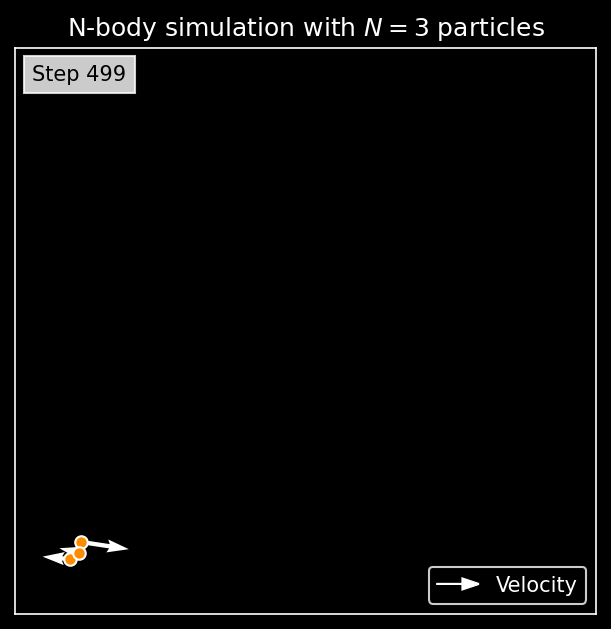

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5,5), dpi=150)

ax.tick_params(labelbottom=False, labelleft=False, left=False, bottom=False)

# Reinitialise particles.
pos, vel = init_dof(npt=npt)

# A helper function to make a nice-looking legend for our arrows
# from https://stackoverflow.com/a/22349717
def make_legend_arrow(legend, orig_handle,
          xdescent, ydescent,
          width, height, fontsize):
    p = matplotlib.patches.FancyArrow(0, 0.5*height, width, 0, length_includes_head=True, head_width=0.75*height)
    return p

for index_in_timestep, time in enumerate(timesteps):
    ax.clear()

    ax.set_title(f'N-body simulation with $N={npt}$ particles')
    step_label = ax.text(0.03, .97, f'Step {index_in_timestep}',
            transform=ax.transAxes, verticalalignment='top', c='k',
            bbox=dict(color='w', alpha=0.8))

    dvel                        = np.zeros_like(vel)
    dpos                        = np.zeros_like(pos)
    acc                         = np.zeros_like(pos)

    for index_in_particle in range(npt):
        acc[index_in_particle]  = g_at_pos(pos[index_in_particle], pos, mass, epsilon=0.1)

        # Update velocities. 
        dvel[index_in_particle] = dt * acc[index_in_particle]

        # Update positions.
        dpos[index_in_particle] = dt * vel[index_in_particle]           

    vel += dvel - drag*vel
    pos += dpos

    # Our simulation has periodic boundaries, if you go off one side you come back on the other!
    pos = pos % 1.

    ax.scatter(pos[:,0], pos[:,1], color='darkorange', edgecolor='w')

    # Draw arrows representing the velocity and acceleration vectors, if requested
    # The code here is a little verbose to get nice-looking arrows in the legend
    arrows = []
    if draw_vel:
        ax.quiver(pos[:,0], pos[:,1], vel[:,0], vel[:,1], color='w', zorder=0)
        arrows += [matplotlib.patches.FancyArrow(0,0, 0.5, 0.6, label='Velocity', color='w')]

    if draw_acc:
        ax.quiver(pos[:,0], pos[:,1], acc[:,0], acc[:,1], color='darkorange', zorder=0)
        arrows += [matplotlib.patches.FancyArrow(0,0, 0.5, 0.6, label='Accel', color='darkorange')]

    if draw_vel or draw_acc:
        ax.legend(handles=arrows, handler_map={matplotlib.patches.FancyArrow:matplotlib.legend_handler.HandlerPatch(patch_func=make_legend_arrow)},
                 facecolor='k', edgecolor='white', framealpha=0.8,
                 loc='lower right')

    ax.set_xlim(0., 1.)
    ax.set_ylim(0., 1.)

    fig.canvas.draw()

Try playing around with the settings!  More than 100 particles won't run very smoothly, however.

With the default settings, you'll find that the particles tend fall into one or two clumps before too long.  This is due to the drag that we put in.  The drag simulates the effect that the expanding universe has on real dark matter particles, which is to slow them down and cause them to group together.  These clumps are known as *halos*, and form "galactic nurseries" where gas can gather to form new stars and galaxies.

Now, when DESI scientists run huge simulations, such as those run on Summit, a total of ~48 _trillion_ particles are solved for.  Don't try this here!  But the results are really quite extraordinary (skip to 6 mins 45 seconds if you're impatient to see the result!):

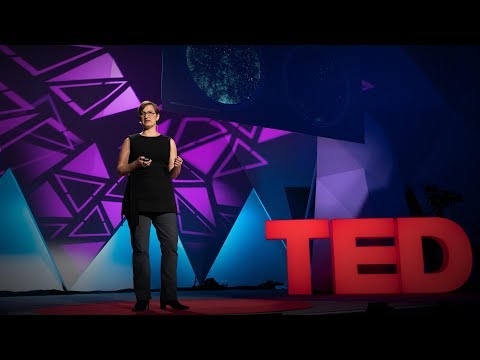

In [ ]:
YouTubeVideo('LQMLFryA_7k', width=800, height=400)

With this great success, comes added responsibility.  Global computing infrastructure (the data centers that power the internet, the cloud, and supercomputers like Summit),  while fantastic for DESI and science, now has a [carbon footprint](https://en.wikipedia.org/wiki/Carbon_footprint) comparable to the [world airline industry](https://www.hpcwire.com/solution_content/ibm/cross-industry/five-tips-to-reduce-your-hpc-carbon-footprint/) and consumes the same amount of electicity as the country of Iran (82 million people!).  

More worrying still, this will soon grow from 2% of the World's energy consumption, to ~30%.  An extraordinary rate! 

Fortunately, Summit is also among the greenest of supercomputers.  It's 14.7 GFlops/watt means a #1 ranking on the [global Green 500 list 2019](https://www.top500.org/lists/green500/2019/06/).

<img src="https://github.com/sheejong/desihigh/blob/main/desihigh/images/Sequoia.jpg?raw=1" alt="Drawing" style="width: 800px;"/>

### Footnote
1. Well, at least Summit *was* the world's fastest supercomputer while DESI scientists were using it in early 2020.  Japan's Fugaku supercomputer overtook Summit in June 2020.  The world's 500 fastest supercomputers are tracked on the "Top500" website here: https://www.top500.org/lists/top500/2020/06/.  Better luck next year, USA!